# Learning Curves for New Text Datasets

We test random selection on various datasets: 

* IMDB
* 20NewsGroups 
* NSF
* Arxiv
* Amazon reviews



In [1]:
## Imports 
%matplotlib inline

STRUCTURED = '/Users/maru/MyCode/structured'
IMDB_DATA='/Users/maru/MyCode/data/imdb'
SRAA_DATA='/Users/maru/MyCode/data/sraa'
TWIITER_DATA = '/Users/maru/MyCode/data/twitter'

# STRUCTURED = '/Users/maru/My Code/structured'
# IMDB_DATA='/Users/maru/Dataset/aclImdb'
# SRAA_DATA='/Users/maru/Dataset/aviation/data'
# TWIITER_DATA = '/Users/maru/Dataset/twitter'

import sys
import os
sys.path.append(os.path.abspath(STRUCTURED))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import utilities.experimentutils as exputil
import utilities.datautils as datautil
import numpy as np
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re 

mpl.style.use('bmh')

vct = CountVectorizer(encoding='ISO-8859-1',min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))


def load_data(dataname, path, vct):
    import pickle

    DATA_PKL = path + '/{}data.pkl'.format(dataname)

    if os.path.isfile(DATA_PKL):
        print "Loading existing."
        vct , data = pickle.load(open(DATA_PKL, 'rb'))

        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)

    else:
        data = datautil.load_dataset(dataname, path, categories='religion', rnd=5463, shuffle=True)
        data.train.data = np.array(data.train.data, dtype=object)
        data.test.data = np.array(data.test.data, dtype=object)
        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)
        pickle.dump((vct, data), open(DATA_PKL, 'wb'))


    return data, vct

def cv_score(clf, data):
    print
    scores = cross_validation.cross_val_score(clf, data.train.bow, data.train.target, cv=5)
    print "BOW - %s" % clf
    print "Data: %s" % len(data.train.target)
    print("Accuracy 5-folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return score


In [3]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression


data, vct = load_data('imdb', IMDB_DATA, vct)


clfnb = MultinomialNB(fit_prior=True)
clflr = LogisticRegression(penalty='l1')
clfnb = MultinomialNB(fit_prior=True)

cv_score(clfnb, data)
    
cv_score(MultinomialNB(class_prior=[.5,.5]), data)

cv_score(LogisticRegression(penalty='l2'), data)


Loading existing.

BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 24991
Accuracy 5-folds: 0.84 (+/- 0.01)

BOW - MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True)
Data: 24991
Accuracy 5-folds: 0.84 (+/- 0.01)

BOW - LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Data: 24991
Accuracy 5-folds: 0.88 (+/- 0.01)


In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    from sklearn.learning_curve import learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    return test_scores_mean, test_scores_std

font = {'family' : 'Arial',
        'size'   : 16}

mpl.rc('font', **font)
import itertools
def plot_cross_validation(title, test, stdev, ylim=None, train_sizes=np.linspace(.1, 1.0, 5), labels=None):
    cvt = mpl.colors.ColorConverter()
    cls = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    color = itertools.cycle([cvt.to_rgb(c) for c in cls])

    plt.figure(figsize=(1.618*6,6))
    
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    pars2 = {'linewidth': 2,  'mfc': 'white', 'markersize': 9, 
            'mew': 1, 'alpha': 1, 'fillstyle': 'full', 'dash_capstyle': 'round'}
    
    for test_scores_mean, test_scores_std,l in zip(test, stdev, labels):
        current_color = color.next()
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
        darker = ( max(current_color[0] - .2, 0), max(0, current_color[1] - .2), max(0, current_color[2] - .2))
        pars2.update({'mfc': current_color,'mec': darker})
        plt.plot(train_sizes, test_scores_mean, 'o-', label=l,**pars2)

    plt.legend(loc="best")

    return plt



In [160]:
from sklearn.cross_validation import StratifiedKFold
#np.linspace(.1, 1.0, 5)
def cv_curve(data, n_folds=5, title=''):
    skf = StratifiedKFold(data.train.target, n_folds=n_folds,random_state=1233333)
    title = "Learning Curves MNB and LR - %s" % title 

    sizes = range(50, min(2001, len(data.train.target)/5*4), 100)
    nb = MultinomialNB()
    avg1, std1 = plot_learning_curve(nb, title, data.train.bow, data.train.target, ylim=(0.45, 1.01), cv=skf, 
                                     n_jobs=1, train_sizes=sizes)

    lr  = LogisticRegression(penalty='l1')
    avg2, std2 = plot_learning_curve(lr, title, data.train.bow, data.train.target, (0.45, 1.01), cv=skf, 
                                     n_jobs=1, train_sizes=sizes)

    plot_cross_validation(title,[avg1, avg2], [std1, std2], (0.45, 1.01), 
                          train_sizes=sizes,
                          labels=["{}-a={}".format(nb.__class__.__name__, nb.alpha),
                                  "{}-Penalty={}-C={}".format(lr.__class__.__name__, lr.penalty, lr.C)] )

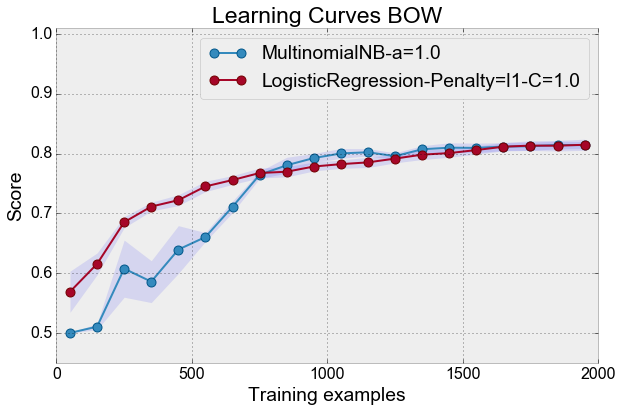

In [6]:
cv_curve(data, n_folds=5)
cv_score(MultinomialNB(), data)
#load other datset, test classifier
#arxiv

In [172]:
cv_score(MultinomialNB(), data)


BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 24991
Accuracy 5-folds: 0.84 (+/- 0.01)


Loading existing.


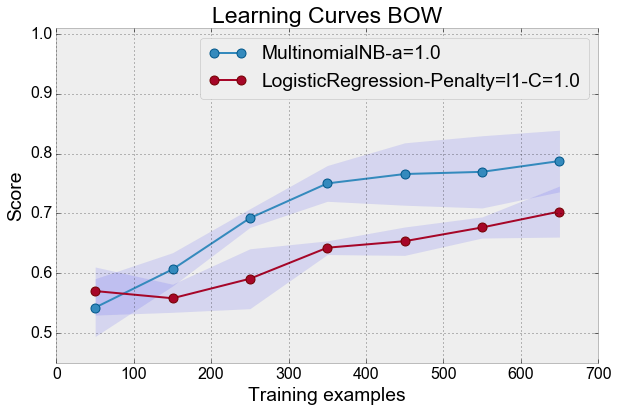

In [7]:
vct2 = CountVectorizer(encoding='ISO-8859-1',min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))

ng20, vct2 = load_data('20news', '.', vct2)
cv_curve(ng20, n_folds=5)


In [8]:
cv_score(MultinomialNB(),ng20)
cv_score(LogisticRegression(penalty='l1'),ng20)
cv_score(LogisticRegression(penalty='l2'),ng20)


BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 828
Accuracy 5-folds: 0.79 (+/- 0.10)

BOW - LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Data: 828
Accuracy 5-folds: 0.69 (+/- 0.09)

BOW - LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Data: 828
Accuracy 5-folds: 0.73 (+/- 0.06)


In [9]:
# Amazon fine food reviews

import sqlite3
import string
from sklearn.datasets import base as bunch

AMAZON_DATA='/Users/maru/MyCode/data/amazon-fine-foods'

def load_amazonfood(path, vct):
    rnd = np.random.RandomState(12756)
    con = sqlite3.connect(path + '/database.sqlite')

    def partition(x):
        if x < 3:
            return 'negative'
        return 'positive'

    res = con.execute("SELECT Score, Text FROM Reviews WHERE Score !=3")

    messages={'Score': [], 'Text':[]}

    for row in res:
        messages['Score'].append(row[0])
        messages['Text'].append(row[1])


    Score = np.array(messages['Score'])
    Score = np.array(map(partition, Score))
    # Summary = messages['Summary']
    Text = np.array(messages['Text'])
    message = None
    print len(Score), len(Text)
    
#     idx = range(len(Score))
    
#     pos = idx[Score=='positive']
#     neg = idx[Score=='negative']
    
#     N = len(pos)
#     print "N=%s" % N
    
#     new_pos = pos[(rnd.random_integers(N) - 1)[:len(neg)]]
#     Score = np.append(Score[neg], Score[new_pos])
#     Text = np.append(Text[neg], Text[new_pos])
    
    data = bunch.Bunch()
    
#     data.train =  bunch.Bunch(data=Text, target = Score, bow = vct.fit_transform(Text))
    
#     return data, vct
    return Score, Text

vct3 = CountVectorizer(encoding='ISO-8859-1',min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))

# amazon, vct3 = load_amazonfood(AMAZON_DATA,  vct3)
score, text = load_amazonfood(AMAZON_DATA,  vct3)

# cv_curve(amazon, n_folds=5)



525814 525814


In [19]:
from collections import Counter 

c = Counter(score)

print c.most_common(5)

[('positive', 443777), ('negative', 82037)]


In [11]:
print 82037./(443777+82037), 443777+82037

0.156019048561 525814


In [15]:
vct3 = CountVectorizer(min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))
food = vct3.fit_transform(text)


In [ ]:
rnd = np.random.RandomState(3637)
idx = range(len(score))
rnd.shuffle(idx)
food_data = bunch.Bunch(train=bunch.Bunch(bow=food[idx], target=score[idx]))
cv_curve(food_data, n_folds=5)

In [60]:
pos = [i for i,s in enumerate(score) if s == 'positive']
neg = [i for i,s in enumerate(score) if s == 'negative']
new_sample = pos[:len(neg)][:10000] + neg[:10000]
rnd.shuffle(new_sample)
sampled = food[new_sample]
sampled_target= score[new_sample]
tmp_data = bunch.Bunch(train=bunch.Bunch(bow=sampled, target=sampled_target))
# cv_curve(, n_folds=5)


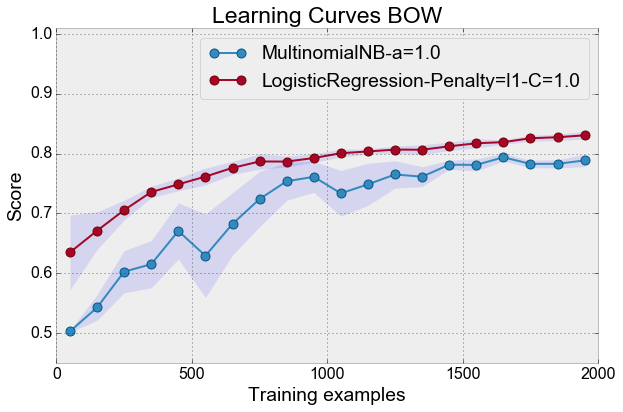

In [42]:
cv_curve(tmp_data, n_folds=5)

In [58]:
cv_score(MultinomialNB(),tmp_data)
cv_score(MultinomialNB(alpha=0.1),tmp_data)
cv_score(LogisticRegression(penalty='l1'),tmp_data)


BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 20000
Accuracy 5-folds: 0.87 (+/- 0.01)

BOW - MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
Data: 20000
Accuracy 5-folds: 0.87 (+/- 0.01)

BOW - LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Data: 20000
Accuracy 5-folds: 0.89 (+/- 0.01)


In [46]:
cc = Counter(score[idx])
print cc.most_common(3)

[('positive', 443777), ('negative', 82037)]


In [62]:
sampled_target[:10]

array(['positive', 'negative', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'negative', 'negative'], 
      dtype='|S8')

In [75]:
def print_top_terms(model, terms, n=20):
    print '\nTop Coefficients'
    coef = model.coef_[0]
    srted = np.argsort(coef)
    topi = srted[::-1][:n]
    boti = srted[:n]
    terms = np.array(terms)
    #"\n".join('%s\t%.2f' % (names[j], coef[j]) for j in np.argsort(coef)[::-1] if coef[j] != 0)
    print 'Class-0 Terms:\n' + '\n'.join('%s (%.2f)' % (n, c) for n, c in zip(terms[topi], coef[topi]) if c != 0)
    print '\nClass-1 Terms:\n' + '\n'.join('%s (%.2f)' % (n, c) for n, c in zip(terms[boti], coef[boti]) if c != 0)
    print '\nintercept=%g' % model.intercept_

def print_terms_and_coef(row, terms, coef):
    indices = sorted(row.indices, key=lambda x: coef[x])
    print 'Top Terms:'
    for i in indices:
        if coef[i] != 0:
            print terms[i], "%.3f" % coef[i]
    print
print 

In [77]:
model = LogisticRegression(penalty='l1').fit(sampled, sampled_target)
model = MultinomialNB().fit(sampled, sampled_target)
print_top_terms(model, vct3.get_feature_names(), n=10)


Top Coefficients
Class-0 Terms:
the (-3.34)
i (-3.43)
and (-3.62)
a (-3.71)
it (-3.89)
to (-3.93)
of (-4.18)
is (-4.22)
this (-4.33)
br (-4.43)

Class-1 Terms:
jail (-13.62)
natra (-13.62)
natrataste (-13.62)
natrazyle (-13.62)
natrual (-13.62)
natsukashii (-13.62)
natto (-13.62)
nattokinase (-13.62)
natually (-13.62)
natuaral (-13.62)

intercept=-0.693147


In [120]:
ARXIV_DATA= '/Users/maru/MyCode/data/arxiv'
from sklearn.datasets import load_files
def load_arxiv(path, category=None, subset="all", shuffle=True, rnd=2356, percent=.5):
    """
    load text files from Aviation-auto dataset from folders to memory. It will return a 25-75 percent train test split
    :param path: path of the root directory of the data
    :param subset: what data will be loaded, train or test or all
    :param shuffle:
    :param rnd: random seed value
    :param vct: vectorizer
    :return: :raise ValueError:
    """
    from sklearn.cross_validation import ShuffleSplit

    categories = {'ai': ['cs.AI', 'cs.LG'],
                  'ai2': ['cs.AI', 'stat.ML'],
                  'ml': ['stat.ML', 'cs.LG'],
                  'co':['cs.CC','cs.LO'],
                  'db2':['cs.DB','cs.SE'],
                  'la':['cs.CL','cs.SE'],
                  'db': ['cs.DB', 'cs.IR'],
                  'cl':['cs.CL','stat.ML'],
    }

    cat = category
#     if category is not None:
#         cat = categories[category]

    data = bunch.Bunch()

    if subset in ('train', 'test'):
        raise ValueError("We are not ready for train test aviation data yet")
    elif subset == "all":
        data = load_files(path, encoding="latin1", load_content=True, random_state=rnd, categories=cat)
        data.data = np.array(data.data, dtype=object)
    else:
        raise ValueError("Subset can only be 'train', 'test' or 'all', got '%s'" % subset)

    indices = ShuffleSplit(len(data.data), n_iter=1, test_size=percent, random_state=rnd)
    for train_ind, test_ind in indices:
        data = bunch.Bunch(train=bunch.Bunch(data=data.data[train_ind], target=data.target[train_ind],
                                             filenames=data.filenames[train_ind], target_names=data.target_names),
                           test=bunch.Bunch(data=data.data[test_ind], target=data.target[test_ind],
                                            filenames=data.filenames[test_ind], target_names=data.target_names))

    if shuffle:
        random_state = np.random.RandomState(rnd)
        indices = np.arange(data.train.target.shape[0])
        random_state.shuffle(indices)
        data.train.filenames = data.train.filenames[indices]
        data.train.target = data.train.target[indices]
        # Use an object array to shuffle: avoids memory copy
        data_lst = np.array(data.train.data, dtype=object)
        data_lst = data_lst[indices]
        data.train.data = data_lst
        data.test.data = np.array(data.test.data, dtype=object)

    return data

In [171]:
cats = ['cs.AI', 'cs.CC', 'cs.CL', 'cs.CR', 'cs.DB', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'stat.ML', 
        'cs.NI', 'cs.GT', 'cs.MA', 'cs.PL', 'cs.SE', 'cs.NE', 'cs.PF', 'cs.SI']

def savefig(name):
    plt.savefig("../graphs/"+name + ".pdf", bbox_inches="tight", dpi=200, transparent=True)



from itertools import combinations

combs = combinations(cats, 2)

combs = [['cs.DB','cs.IR'],['cs.DB','cs.SI'],['cs.IR','cs.NE'],
         ['cs.LO','cs.PL'],['cs.NE','cs.SI'],['cs.SE','cs.SI']]
combs = [['cs.AI',vs] for vs in ['cs.CR', 'cs.DB', 'cs.GT', 'cs.IR', 'cs.LG', 'cs.LO', 'cs.NE', 'cs.PL', 'stat.ML']]


for com in combs:
    try:
        print "*" * 20
        print com
        arxiv1 = load_arxiv(ARXIV_DATA, category=com)
        vct4= CountVectorizer(min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))
        arxiv1.train.bow = vct4.fit_transform(arxiv1.train.data)
        print "Label distribution: %s" % (1. * sum(arxiv1.train.target)/ len(arxiv1.train.target))
        cv_score(MultinomialNB(),arxiv1)
#         cv_curve(arxiv1, n_folds=5, title="{} vs. {}".format(*com))
#         savefig("{}-{}".format(*com))
    except ValueError:
        print "error", com


********************
['cs.AI', 'cs.CR']
Label distribution: 0.294483450351

BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 4985
Accuracy 5-folds: 0.96 (+/- 0.01)
********************
['cs.AI', 'cs.DB']
Label distribution: 0.263530391341

BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 4804
Accuracy 5-folds: 0.90 (+/- 0.02)
********************
['cs.AI', 'cs.GT']
Label distribution: 0.238867271941

BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 4626
Accuracy 5-folds: 0.95 (+/- 0.01)
********************
['cs.AI', 'cs.IR']
Label distribution: 0.278691896339

BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 4862
Accuracy 5-folds: 0.89 (+/- 0.02)
********************
['cs.AI', 'cs.LG']
Label distribution: 0.506643806258

BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 6999
Accuracy 5-folds: 0.85 (+/- 0.01)
********************
['cs.AI', 'cs.LO']
Label distribution: 0.29385699